In [2]:
# Importing the required libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder,MinMaxScaler 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow._api.v1.keras.preprocessing import image
from tensorflow._api.v1.keras.models import Sequential, load_model
from tensorflow._api.v1.keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow._api.v1.keras.preprocessing.image import ImageDataGenerator
from tensorflow._api.v1.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow._api.v1.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras import regularizers

import io
from io import BytesIO

import cv2 as cv
import imutils
import time

import requests
import tempfile
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

/Users/isla/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/isla/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/isla/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/isla/opt/anaconda3/envs/tf/lib/python3.6/s

In [3]:
# Define two directories 
train_dir='./dataset/archive/train_cleaned'
test_dir = './dataset/archive/test'

In [4]:
# Set image size
img_size=48


# Process the images（ Enhance data ）
train_data_gen = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    rescale = 1./255,
                                    validation_split = 0.2)
test_data_gen = ImageDataGenerator(rescale=1./255,
                                   validation_split = 0.2)

# Read data in batches from the dataset
train_set = train_data_gen.flow_from_directory(directory=train_dir,
                                               target_size=(img_size, img_size),
                                               batch_size=64,
                                               color_mode="grayscale",
                                               class_mode='categorical',
                                               subset='training')
test_set = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(img_size, img_size),
                                             batch_size=64,
                                             color_mode="grayscale",
                                             class_mode='categorical',
                                             subset='validation')

/Users/isla/opt/anaconda3/envs/tf/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 21341 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [5]:
# Create the CNN model

model= Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

# Print out the model layers and parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 512)       590336    
__________

In [6]:
# Train the model

epochs= 50
batch_szie=60
history = model.fit(x = train_set,
                    epochs = epochs,
                    validation_data = test_set)

Epoch 1/50
334/334 [==============================] - 864s 3s/step - loss: 2.4840 - acc: 0.2760 - val_loss: 1.9309 - val_acc: 0.2493
Epoch 2/50
334/334 [==============================] - 819s 2s/step - loss: 1.7852 - acc: 0.3043 - val_loss: 1.7122 - val_acc: 0.3520
Epoch 3/50
334/334 [==============================] - 866s 3s/step - loss: 1.6801 - acc: 0.3523 - val_loss: 1.6407 - val_acc: 0.3994
Epoch 4/50
334/334 [==============================] - 778s 2s/step - loss: 1.6115 - acc: 0.3885 - val_loss: 1.5502 - val_acc: 0.4253
Epoch 5/50
334/334 [==============================] - 755s 2s/step - loss: 1.5608 - acc: 0.4165 - val_loss: 1.5275 - val_acc: 0.4448
Epoch 6/50
334/334 [==============================] - 763s 2s/step - loss: 1.5074 - acc: 0.4403 - val_loss: 1.4746 - val_acc: 0.4567
Epoch 7/50
334/334 [==============================] - 761s 2s/step - loss: 1.4665 - acc: 0.4589 - val_loss: 1.4361 - val_acc: 0.4874
Epoch 8/50
334/334 [==============================] - 733s 2s/step - 

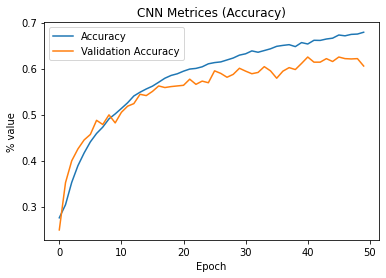

In [7]:
# Show the results of the training - Accuracy

plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('CNN Metrices (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

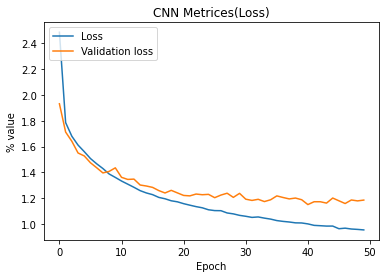

In [8]:
# Show the results of the training - Loss

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('CNN Metrices(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [9]:
# Save the model
model.save("My_model_clean.h5")

In [10]:
df = pd.read_csv("data_moods.csv")
df.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [11]:
col_features = df.columns[6:-3]
col_features

Index(['length', 'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo'],
      dtype='object')

In [12]:
# Normalize all the feature data ranging from [0,1]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

# Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)

In [14]:
# Create train and test data

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [15]:
# Create the model by using well-established library keras-classifier
def base_model():
    model = Sequential()
    model.add(Dense(8,input_dim=10,activation='relu')) # 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(4,activation='softmax')) # 1 layer with output 3 and softmax function
    # compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [16]:
estimator = KerasClassifier(build_fn=base_model,epochs=300, batch_size=200)

In [17]:
# Cross-validation to evaluate the keras model

kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

Epoch 1/300
617/617 [==============================] - 1s 859us/step - loss: 1.4063 - acc: 0.4165
Epoch 2/300
617/617 [==============================] - 0s 10us/step - loss: 1.3952 - acc: 0.4198
Epoch 3/300
617/617 [==============================] - 0s 14us/step - loss: 1.3849 - acc: 0.4246
Epoch 4/300
617/617 [==============================] - 0s 15us/step - loss: 1.3750 - acc: 0.4311
Epoch 5/300
617/617 [==============================] - 0s 14us/step - loss: 1.3654 - acc: 0.4311
Epoch 6/300
617/617 [==============================] - 0s 12us/step - loss: 1.3561 - acc: 0.4279
Epoch 7/300
617/617 [==============================] - 0s 14us/step - loss: 1.3475 - acc: 0.4279
Epoch 8/300
617/617 [==============================] - 0s 16us/step - loss: 1.3391 - acc: 0.4311
Epoch 9/300
617/617 [==============================] - 0s 14us/step - loss: 1.3309 - acc: 0.4311
Epoch 10/300
617/617 [==============================] - 0s 13us/step - loss: 1.3228 - acc: 0.4327
Epoch 11/300
617/617 [======

617/617 [==============================] - 0s 15us/step - loss: 0.9393 - acc: 0.6596
Epoch 85/300
617/617 [==============================] - 0s 15us/step - loss: 0.9358 - acc: 0.6661
Epoch 86/300
617/617 [==============================] - 0s 16us/step - loss: 0.9322 - acc: 0.6661
Epoch 87/300
617/617 [==============================] - 0s 10us/step - loss: 0.9286 - acc: 0.6694
Epoch 88/300
617/617 [==============================] - 0s 14us/step - loss: 0.9251 - acc: 0.6710
Epoch 89/300
617/617 [==============================] - 0s 11us/step - loss: 0.9216 - acc: 0.6775
Epoch 90/300
617/617 [==============================] - 0s 13us/step - loss: 0.9182 - acc: 0.6840
Epoch 91/300
617/617 [==============================] - 0s 11us/step - loss: 0.9149 - acc: 0.6856
Epoch 92/300
617/617 [==============================] - 0s 10us/step - loss: 0.9115 - acc: 0.6872
Epoch 93/300
617/617 [==============================] - 0s 12us/step - loss: 0.9079 - acc: 0.6872
Epoch 94/300
617/617 [===========

617/617 [==============================] - 0s 10us/step - loss: 0.6964 - acc: 0.7261
Epoch 168/300
617/617 [==============================] - 0s 11us/step - loss: 0.6942 - acc: 0.7261
Epoch 169/300
617/617 [==============================] - 0s 10us/step - loss: 0.6918 - acc: 0.7293
Epoch 170/300
617/617 [==============================] - 0s 11us/step - loss: 0.6895 - acc: 0.7293
Epoch 171/300
617/617 [==============================] - 0s 11us/step - loss: 0.6873 - acc: 0.7310
Epoch 172/300
617/617 [==============================] - 0s 11us/step - loss: 0.6851 - acc: 0.7342
Epoch 173/300
617/617 [==============================] - 0s 10us/step - loss: 0.6828 - acc: 0.7358
Epoch 174/300
617/617 [==============================] - 0s 10us/step - loss: 0.6805 - acc: 0.7374
Epoch 175/300
617/617 [==============================] - 0s 10us/step - loss: 0.6784 - acc: 0.7374
Epoch 176/300
617/617 [==============================] - 0s 10us/step - loss: 0.6764 - acc: 0.7391
Epoch 177/300
617/617 [=

617/617 [==============================] - 0s 9us/step - loss: 0.5632 - acc: 0.7893
Epoch 251/300
617/617 [==============================] - 0s 11us/step - loss: 0.5622 - acc: 0.7893
Epoch 252/300
617/617 [==============================] - 0s 10us/step - loss: 0.5611 - acc: 0.7877
Epoch 253/300
617/617 [==============================] - 0s 9us/step - loss: 0.5598 - acc: 0.7893
Epoch 254/300
617/617 [==============================] - 0s 11us/step - loss: 0.5590 - acc: 0.7909
Epoch 255/300
617/617 [==============================] - 0s 9us/step - loss: 0.5581 - acc: 0.7958
Epoch 256/300
617/617 [==============================] - 0s 12us/step - loss: 0.5573 - acc: 0.7942
Epoch 257/300
617/617 [==============================] - 0s 11us/step - loss: 0.5563 - acc: 0.7925
Epoch 258/300
617/617 [==============================] - 0s 12us/step - loss: 0.5552 - acc: 0.7942
Epoch 259/300
617/617 [==============================] - 0s 9us/step - loss: 0.5544 - acc: 0.7925
Epoch 260/300
617/617 [=====

617/617 [==============================] - 0s 10us/step - loss: 1.1394 - acc: 0.6029
Epoch 33/300
617/617 [==============================] - 0s 10us/step - loss: 1.1314 - acc: 0.6094
Epoch 34/300
617/617 [==============================] - 0s 9us/step - loss: 1.1233 - acc: 0.6126
Epoch 35/300
617/617 [==============================] - 0s 11us/step - loss: 1.1153 - acc: 0.6191
Epoch 36/300
617/617 [==============================] - 0s 9us/step - loss: 1.1071 - acc: 0.6191
Epoch 37/300
617/617 [==============================] - 0s 12us/step - loss: 1.0990 - acc: 0.6224
Epoch 38/300
617/617 [==============================] - 0s 11us/step - loss: 1.0910 - acc: 0.6272
Epoch 39/300
617/617 [==============================] - 0s 13us/step - loss: 1.0830 - acc: 0.6337
Epoch 40/300
617/617 [==============================] - 0s 10us/step - loss: 1.0751 - acc: 0.6353
Epoch 41/300
617/617 [==============================] - 0s 14us/step - loss: 1.0675 - acc: 0.6418
Epoch 42/300
617/617 [=============

617/617 [==============================] - 0s 9us/step - loss: 0.6873 - acc: 0.7925
Epoch 116/300
617/617 [==============================] - 0s 12us/step - loss: 0.6845 - acc: 0.7925
Epoch 117/300
617/617 [==============================] - 0s 9us/step - loss: 0.6818 - acc: 0.7877
Epoch 118/300
617/617 [==============================] - 0s 12us/step - loss: 0.6792 - acc: 0.7780
Epoch 119/300
617/617 [==============================] - 0s 10us/step - loss: 0.6766 - acc: 0.7812
Epoch 120/300
617/617 [==============================] - 0s 11us/step - loss: 0.6738 - acc: 0.7812
Epoch 121/300
617/617 [==============================] - 0s 10us/step - loss: 0.6712 - acc: 0.7780
Epoch 122/300
617/617 [==============================] - 0s 11us/step - loss: 0.6687 - acc: 0.7796
Epoch 123/300
617/617 [==============================] - 0s 11us/step - loss: 0.6661 - acc: 0.7812
Epoch 124/300
617/617 [==============================] - 0s 10us/step - loss: 0.6636 - acc: 0.7796
Epoch 125/300
617/617 [===

617/617 [==============================] - 0s 12us/step - loss: 0.5512 - acc: 0.8055
Epoch 198/300
617/617 [==============================] - 0s 13us/step - loss: 0.5507 - acc: 0.8006
Epoch 199/300
617/617 [==============================] - 0s 12us/step - loss: 0.5499 - acc: 0.8023
Epoch 200/300
617/617 [==============================] - 0s 13us/step - loss: 0.5485 - acc: 0.8039
Epoch 201/300
617/617 [==============================] - 0s 10us/step - loss: 0.5474 - acc: 0.8023
Epoch 202/300
617/617 [==============================] - 0s 17us/step - loss: 0.5461 - acc: 0.8023
Epoch 203/300
617/617 [==============================] - 0s 11us/step - loss: 0.5451 - acc: 0.8023
Epoch 204/300
617/617 [==============================] - 0s 14us/step - loss: 0.5441 - acc: 0.7990
Epoch 205/300
617/617 [==============================] - 0s 11us/step - loss: 0.5430 - acc: 0.7958
Epoch 206/300
617/617 [==============================] - 0s 14us/step - loss: 0.5421 - acc: 0.7990
Epoch 207/300
617/617 [=

617/617 [==============================] - 0s 10us/step - loss: 0.4920 - acc: 0.8006
Epoch 280/300
617/617 [==============================] - 0s 10us/step - loss: 0.4914 - acc: 0.8039
Epoch 281/300
617/617 [==============================] - 0s 11us/step - loss: 0.4908 - acc: 0.8023
Epoch 282/300
617/617 [==============================] - 0s 11us/step - loss: 0.4903 - acc: 0.8071
Epoch 283/300
617/617 [==============================] - 0s 10us/step - loss: 0.4901 - acc: 0.8071
Epoch 284/300
617/617 [==============================] - 0s 12us/step - loss: 0.4897 - acc: 0.8071
Epoch 285/300
617/617 [==============================] - 0s 10us/step - loss: 0.4894 - acc: 0.8136
Epoch 286/300
617/617 [==============================] - 0s 10us/step - loss: 0.4888 - acc: 0.8136
Epoch 287/300
617/617 [==============================] - 0s 12us/step - loss: 0.4884 - acc: 0.8136
Epoch 288/300
617/617 [==============================] - 0s 10us/step - loss: 0.4878 - acc: 0.8152
Epoch 289/300
617/617 [=

617/617 [==============================] - 0s 10us/step - loss: 0.9466 - acc: 0.7034
Epoch 63/300
617/617 [==============================] - 0s 12us/step - loss: 0.9389 - acc: 0.7034
Epoch 64/300
617/617 [==============================] - 0s 11us/step - loss: 0.9312 - acc: 0.7066
Epoch 65/300
617/617 [==============================] - 0s 10us/step - loss: 0.9237 - acc: 0.7083
Epoch 66/300
617/617 [==============================] - 0s 12us/step - loss: 0.9164 - acc: 0.7115
Epoch 67/300
617/617 [==============================] - 0s 10us/step - loss: 0.9088 - acc: 0.7180
Epoch 68/300
617/617 [==============================] - 0s 13us/step - loss: 0.9015 - acc: 0.7212
Epoch 69/300
617/617 [==============================] - 0s 10us/step - loss: 0.8944 - acc: 0.7212
Epoch 70/300
617/617 [==============================] - 0s 12us/step - loss: 0.8873 - acc: 0.7196
Epoch 71/300
617/617 [==============================] - 0s 10us/step - loss: 0.8803 - acc: 0.7164
Epoch 72/300
617/617 [===========

617/617 [==============================] - 0s 10us/step - loss: 0.5971 - acc: 0.8055
Epoch 146/300
617/617 [==============================] - 0s 10us/step - loss: 0.5952 - acc: 0.8055
Epoch 147/300
617/617 [==============================] - 0s 12us/step - loss: 0.5934 - acc: 0.8055
Epoch 148/300
617/617 [==============================] - 0s 11us/step - loss: 0.5917 - acc: 0.8055
Epoch 149/300
617/617 [==============================] - 0s 10us/step - loss: 0.5901 - acc: 0.8039
Epoch 150/300
617/617 [==============================] - 0s 13us/step - loss: 0.5883 - acc: 0.8039
Epoch 151/300
617/617 [==============================] - 0s 10us/step - loss: 0.5868 - acc: 0.8023
Epoch 152/300
617/617 [==============================] - 0s 13us/step - loss: 0.5851 - acc: 0.8023
Epoch 153/300
617/617 [==============================] - 0s 10us/step - loss: 0.5836 - acc: 0.8023
Epoch 154/300
617/617 [==============================] - 0s 11us/step - loss: 0.5819 - acc: 0.8039
Epoch 155/300
617/617 [=

617/617 [==============================] - 0s 10us/step - loss: 0.4973 - acc: 0.8088
Epoch 228/300
617/617 [==============================] - 0s 10us/step - loss: 0.4964 - acc: 0.8088
Epoch 229/300
617/617 [==============================] - 0s 11us/step - loss: 0.4961 - acc: 0.8071
Epoch 230/300
617/617 [==============================] - 0s 9us/step - loss: 0.4954 - acc: 0.8071
Epoch 231/300
617/617 [==============================] - 0s 11us/step - loss: 0.4946 - acc: 0.8071
Epoch 232/300
617/617 [==============================] - 0s 10us/step - loss: 0.4939 - acc: 0.8120
Epoch 233/300
617/617 [==============================] - 0s 11us/step - loss: 0.4934 - acc: 0.8152
Epoch 234/300
617/617 [==============================] - 0s 11us/step - loss: 0.4927 - acc: 0.8120
Epoch 235/300
617/617 [==============================] - 0s 9us/step - loss: 0.4924 - acc: 0.8136
Epoch 236/300
617/617 [==============================] - 0s 11us/step - loss: 0.4921 - acc: 0.8120
Epoch 237/300
617/617 [===

617/617 [==============================] - 0s 10us/step - loss: 1.4680 - acc: 0.2950
Epoch 10/300
617/617 [==============================] - 0s 11us/step - loss: 1.4587 - acc: 0.2966
Epoch 11/300
617/617 [==============================] - 0s 10us/step - loss: 1.4505 - acc: 0.2950
Epoch 12/300
617/617 [==============================] - 0s 12us/step - loss: 1.4422 - acc: 0.2966
Epoch 13/300
617/617 [==============================] - 0s 10us/step - loss: 1.4344 - acc: 0.2950
Epoch 14/300
617/617 [==============================] - 0s 9us/step - loss: 1.4263 - acc: 0.2982
Epoch 15/300
617/617 [==============================] - 0s 12us/step - loss: 1.4192 - acc: 0.2917
Epoch 16/300
617/617 [==============================] - 0s 10us/step - loss: 1.4126 - acc: 0.2950
Epoch 17/300
617/617 [==============================] - 0s 13us/step - loss: 1.4059 - acc: 0.2982
Epoch 18/300
617/617 [==============================] - 0s 11us/step - loss: 1.3991 - acc: 0.2966
Epoch 19/300
617/617 [============

617/617 [==============================] - 0s 10us/step - loss: 0.9350 - acc: 0.6305
Epoch 93/300
617/617 [==============================] - 0s 10us/step - loss: 0.9290 - acc: 0.6288
Epoch 94/300
617/617 [==============================] - 0s 12us/step - loss: 0.9228 - acc: 0.6272
Epoch 95/300
617/617 [==============================] - 0s 10us/step - loss: 0.9167 - acc: 0.6321
Epoch 96/300
617/617 [==============================] - 0s 11us/step - loss: 0.9108 - acc: 0.6370
Epoch 97/300
617/617 [==============================] - 0s 13us/step - loss: 0.9050 - acc: 0.6386
Epoch 98/300
617/617 [==============================] - 0s 11us/step - loss: 0.8993 - acc: 0.6386
Epoch 99/300
617/617 [==============================] - 0s 10us/step - loss: 0.8937 - acc: 0.6353
Epoch 100/300
617/617 [==============================] - 0s 13us/step - loss: 0.8880 - acc: 0.6353
Epoch 101/300
617/617 [==============================] - 0s 11us/step - loss: 0.8827 - acc: 0.6370
Epoch 102/300
617/617 [========

Epoch 175/300
617/617 [==============================] - 0s 12us/step - loss: 0.6429 - acc: 0.7650
Epoch 176/300
617/617 [==============================] - 0s 10us/step - loss: 0.6405 - acc: 0.7682
Epoch 177/300
617/617 [==============================] - 0s 10us/step - loss: 0.6384 - acc: 0.7747
Epoch 178/300
617/617 [==============================] - 0s 9us/step - loss: 0.6364 - acc: 0.7796
Epoch 179/300
617/617 [==============================] - 0s 15us/step - loss: 0.6345 - acc: 0.7763
Epoch 180/300
617/617 [==============================] - 0s 11us/step - loss: 0.6325 - acc: 0.7763
Epoch 181/300
617/617 [==============================] - 0s 14us/step - loss: 0.6309 - acc: 0.7618
Epoch 182/300
617/617 [==============================] - 0s 10us/step - loss: 0.6293 - acc: 0.7650
Epoch 183/300
617/617 [==============================] - 0s 12us/step - loss: 0.6276 - acc: 0.7666
Epoch 184/300
617/617 [==============================] - 0s 10us/step - loss: 0.6259 - acc: 0.7650
Epoch 185/3

617/617 [==============================] - 0s 10us/step - loss: 0.5407 - acc: 0.7974
Epoch 258/300
617/617 [==============================] - 0s 10us/step - loss: 0.5399 - acc: 0.7974
Epoch 259/300
617/617 [==============================] - 0s 12us/step - loss: 0.5391 - acc: 0.7990
Epoch 260/300
617/617 [==============================] - 0s 10us/step - loss: 0.5383 - acc: 0.7990
Epoch 261/300
617/617 [==============================] - 0s 13us/step - loss: 0.5375 - acc: 0.8006
Epoch 262/300
617/617 [==============================] - 0s 12us/step - loss: 0.5367 - acc: 0.8023
Epoch 263/300
617/617 [==============================] - 0s 12us/step - loss: 0.5361 - acc: 0.8023
Epoch 264/300
617/617 [==============================] - 0s 11us/step - loss: 0.5353 - acc: 0.8006
Epoch 265/300
617/617 [==============================] - 0s 13us/step - loss: 0.5345 - acc: 0.7942
Epoch 266/300
617/617 [==============================] - 0s 11us/step - loss: 0.5343 - acc: 0.7925
Epoch 267/300
617/617 [=

617/617 [==============================] - 0s 10us/step - loss: 1.0094 - acc: 0.6094
Epoch 40/300
617/617 [==============================] - 0s 17us/step - loss: 1.0016 - acc: 0.6045
Epoch 41/300
617/617 [==============================] - 0s 10us/step - loss: 0.9937 - acc: 0.6110
Epoch 42/300
617/617 [==============================] - 0s 15us/step - loss: 0.9863 - acc: 0.6126
Epoch 43/300
617/617 [==============================] - 0s 17us/step - loss: 0.9794 - acc: 0.6078
Epoch 44/300
617/617 [==============================] - 0s 15us/step - loss: 0.9726 - acc: 0.6110
Epoch 45/300
617/617 [==============================] - 0s 14us/step - loss: 0.9658 - acc: 0.6159
Epoch 46/300
617/617 [==============================] - 0s 14us/step - loss: 0.9592 - acc: 0.6207
Epoch 47/300
617/617 [==============================] - 0s 14us/step - loss: 0.9526 - acc: 0.6272
Epoch 48/300
617/617 [==============================] - 0s 12us/step - loss: 0.9462 - acc: 0.6353
Epoch 49/300
617/617 [===========

617/617 [==============================] - 0s 10us/step - loss: 0.6524 - acc: 0.7439
Epoch 123/300
617/617 [==============================] - 0s 14us/step - loss: 0.6500 - acc: 0.7439
Epoch 124/300
617/617 [==============================] - 0s 11us/step - loss: 0.6477 - acc: 0.7391
Epoch 125/300
617/617 [==============================] - 0s 13us/step - loss: 0.6453 - acc: 0.7391
Epoch 126/300
617/617 [==============================] - 0s 9us/step - loss: 0.6431 - acc: 0.7374
Epoch 127/300
617/617 [==============================] - 0s 13us/step - loss: 0.6411 - acc: 0.7342
Epoch 128/300
617/617 [==============================] - 0s 13us/step - loss: 0.6392 - acc: 0.7277
Epoch 129/300
617/617 [==============================] - 0s 12us/step - loss: 0.6373 - acc: 0.7310
Epoch 130/300
617/617 [==============================] - 0s 11us/step - loss: 0.6353 - acc: 0.7310
Epoch 131/300
617/617 [==============================] - 0s 13us/step - loss: 0.6334 - acc: 0.7293
Epoch 132/300
617/617 [==

Epoch 205/300
617/617 [==============================] - 0s 11us/step - loss: 0.5331 - acc: 0.7861
Epoch 206/300
617/617 [==============================] - 0s 11us/step - loss: 0.5321 - acc: 0.7877
Epoch 207/300
617/617 [==============================] - 0s 12us/step - loss: 0.5311 - acc: 0.7861
Epoch 208/300
617/617 [==============================] - 0s 9us/step - loss: 0.5302 - acc: 0.7861
Epoch 209/300
617/617 [==============================] - 0s 12us/step - loss: 0.5295 - acc: 0.7861
Epoch 210/300
617/617 [==============================] - 0s 13us/step - loss: 0.5286 - acc: 0.7844
Epoch 211/300
617/617 [==============================] - 0s 14us/step - loss: 0.5277 - acc: 0.7958
Epoch 212/300
617/617 [==============================] - 0s 11us/step - loss: 0.5271 - acc: 0.7958
Epoch 213/300
617/617 [==============================] - 0s 10us/step - loss: 0.5264 - acc: 0.8006
Epoch 214/300
617/617 [==============================] - 0s 13us/step - loss: 0.5258 - acc: 0.8006
Epoch 215/3

617/617 [==============================] - 0s 10us/step - loss: 0.4845 - acc: 0.7974
Epoch 288/300
617/617 [==============================] - 0s 9us/step - loss: 0.4842 - acc: 0.7974
Epoch 289/300
617/617 [==============================] - 0s 11us/step - loss: 0.4840 - acc: 0.7974
Epoch 290/300
617/617 [==============================] - 0s 11us/step - loss: 0.4837 - acc: 0.7990
Epoch 291/300
617/617 [==============================] - 0s 11us/step - loss: 0.4835 - acc: 0.7990
Epoch 292/300
617/617 [==============================] - 0s 12us/step - loss: 0.4830 - acc: 0.8006
Epoch 293/300
617/617 [==============================] - 0s 10us/step - loss: 0.4828 - acc: 0.8039
Epoch 294/300
617/617 [==============================] - 0s 11us/step - loss: 0.4827 - acc: 0.8055
Epoch 295/300
617/617 [==============================] - 0s 12us/step - loss: 0.4824 - acc: 0.8039
Epoch 296/300
617/617 [==============================] - 0s 9us/step - loss: 0.4820 - acc: 0.8023
Epoch 297/300
617/617 [===

617/617 [==============================] - 0s 10us/step - loss: 0.9431 - acc: 0.6629
Epoch 71/300
617/617 [==============================] - 0s 12us/step - loss: 0.9375 - acc: 0.6710
Epoch 72/300
617/617 [==============================] - 0s 11us/step - loss: 0.9319 - acc: 0.6710
Epoch 73/300
617/617 [==============================] - 0s 11us/step - loss: 0.9263 - acc: 0.6791
Epoch 74/300
617/617 [==============================] - 0s 12us/step - loss: 0.9208 - acc: 0.6840
Epoch 75/300
617/617 [==============================] - 0s 13us/step - loss: 0.9154 - acc: 0.6921
Epoch 76/300
617/617 [==============================] - 0s 12us/step - loss: 0.9100 - acc: 0.7050
Epoch 77/300
617/617 [==============================] - 0s 11us/step - loss: 0.9044 - acc: 0.7099
Epoch 78/300
617/617 [==============================] - 0s 11us/step - loss: 0.8991 - acc: 0.7083
Epoch 79/300
617/617 [==============================] - 0s 11us/step - loss: 0.8939 - acc: 0.7131
Epoch 80/300
617/617 [===========

617/617 [==============================] - 0s 15us/step - loss: 0.6113 - acc: 0.7618
Epoch 154/300
617/617 [==============================] - 0s 18us/step - loss: 0.6090 - acc: 0.7618
Epoch 155/300
617/617 [==============================] - 0s 17us/step - loss: 0.6071 - acc: 0.7634
Epoch 156/300
617/617 [==============================] - 0s 17us/step - loss: 0.6053 - acc: 0.7634
Epoch 157/300
617/617 [==============================] - 0s 20us/step - loss: 0.6033 - acc: 0.7634
Epoch 158/300
617/617 [==============================] - 0s 19us/step - loss: 0.6014 - acc: 0.7634
Epoch 159/300
617/617 [==============================] - 0s 16us/step - loss: 0.5995 - acc: 0.7650
Epoch 160/300
617/617 [==============================] - 0s 17us/step - loss: 0.5977 - acc: 0.7666
Epoch 161/300
617/617 [==============================] - 0s 16us/step - loss: 0.5960 - acc: 0.7650
Epoch 162/300
617/617 [==============================] - 0s 12us/step - loss: 0.5942 - acc: 0.7650
Epoch 163/300
617/617 [=

617/617 [==============================] - 0s 11us/step - loss: 0.5161 - acc: 0.7974
Epoch 236/300
617/617 [==============================] - 0s 11us/step - loss: 0.5155 - acc: 0.7990
Epoch 237/300
617/617 [==============================] - 0s 10us/step - loss: 0.5150 - acc: 0.7990
Epoch 238/300
617/617 [==============================] - 0s 12us/step - loss: 0.5142 - acc: 0.8006
Epoch 239/300
617/617 [==============================] - 0s 14us/step - loss: 0.5134 - acc: 0.8006
Epoch 240/300
617/617 [==============================] - 0s 14us/step - loss: 0.5128 - acc: 0.7974
Epoch 241/300
617/617 [==============================] - 0s 12us/step - loss: 0.5125 - acc: 0.7974
Epoch 242/300
617/617 [==============================] - 0s 13us/step - loss: 0.5120 - acc: 0.7974
Epoch 243/300
617/617 [==============================] - 0s 12us/step - loss: 0.5114 - acc: 0.7974
Epoch 244/300
617/617 [==============================] - 0s 15us/step - loss: 0.5109 - acc: 0.8006
Epoch 245/300
617/617 [=

618/618 [==============================] - 0s 11us/step - loss: 1.2839 - acc: 0.5696
Epoch 18/300
618/618 [==============================] - 0s 11us/step - loss: 1.2755 - acc: 0.5663
Epoch 19/300
618/618 [==============================] - 0s 10us/step - loss: 1.2674 - acc: 0.5615
Epoch 20/300
618/618 [==============================] - 0s 10us/step - loss: 1.2595 - acc: 0.5550
Epoch 21/300
618/618 [==============================] - 0s 11us/step - loss: 1.2514 - acc: 0.5469
Epoch 22/300
618/618 [==============================] - 0s 12us/step - loss: 1.2433 - acc: 0.5388
Epoch 23/300
618/618 [==============================] - 0s 13us/step - loss: 1.2356 - acc: 0.5388
Epoch 24/300
618/618 [==============================] - 0s 11us/step - loss: 1.2277 - acc: 0.5340
Epoch 25/300
618/618 [==============================] - 0s 11us/step - loss: 1.2202 - acc: 0.5340
Epoch 26/300
618/618 [==============================] - 0s 12us/step - loss: 1.2127 - acc: 0.5388
Epoch 27/300
618/618 [===========

618/618 [==============================] - 0s 10us/step - loss: 0.7976 - acc: 0.7573
Epoch 101/300
618/618 [==============================] - 0s 13us/step - loss: 0.7938 - acc: 0.7573
Epoch 102/300
618/618 [==============================] - 0s 13us/step - loss: 0.7901 - acc: 0.7605
Epoch 103/300
618/618 [==============================] - 0s 16us/step - loss: 0.7864 - acc: 0.7605
Epoch 104/300
618/618 [==============================] - 0s 16us/step - loss: 0.7826 - acc: 0.7621
Epoch 105/300
618/618 [==============================] - 0s 14us/step - loss: 0.7790 - acc: 0.7621
Epoch 106/300
618/618 [==============================] - 0s 16us/step - loss: 0.7754 - acc: 0.7638
Epoch 107/300
618/618 [==============================] - 0s 15us/step - loss: 0.7718 - acc: 0.7670
Epoch 108/300
618/618 [==============================] - 0s 15us/step - loss: 0.7682 - acc: 0.7654
Epoch 109/300
618/618 [==============================] - 0s 14us/step - loss: 0.7646 - acc: 0.7638
Epoch 110/300
618/618 [=

618/618 [==============================] - 0s 10us/step - loss: 0.6015 - acc: 0.7848
Epoch 183/300
618/618 [==============================] - 0s 9us/step - loss: 0.6000 - acc: 0.7864
Epoch 184/300
618/618 [==============================] - 0s 11us/step - loss: 0.5987 - acc: 0.7864
Epoch 185/300
618/618 [==============================] - 0s 12us/step - loss: 0.5975 - acc: 0.7832
Epoch 186/300
618/618 [==============================] - 0s 10us/step - loss: 0.5962 - acc: 0.7832
Epoch 187/300
618/618 [==============================] - 0s 11us/step - loss: 0.5950 - acc: 0.7783
Epoch 188/300
618/618 [==============================] - 0s 10us/step - loss: 0.5938 - acc: 0.7783
Epoch 189/300
618/618 [==============================] - 0s 10us/step - loss: 0.5926 - acc: 0.7783
Epoch 190/300
618/618 [==============================] - 0s 11us/step - loss: 0.5912 - acc: 0.7783
Epoch 191/300
618/618 [==============================] - 0s 10us/step - loss: 0.5897 - acc: 0.7783
Epoch 192/300
618/618 [==

618/618 [==============================] - 0s 13us/step - loss: 0.5232 - acc: 0.7896
Epoch 265/300
618/618 [==============================] - 0s 16us/step - loss: 0.5226 - acc: 0.7880
Epoch 266/300
618/618 [==============================] - 0s 13us/step - loss: 0.5220 - acc: 0.7913
Epoch 267/300
618/618 [==============================] - 0s 14us/step - loss: 0.5214 - acc: 0.7896
Epoch 268/300
618/618 [==============================] - 0s 15us/step - loss: 0.5207 - acc: 0.7913
Epoch 269/300
618/618 [==============================] - 0s 17us/step - loss: 0.5201 - acc: 0.7913
Epoch 270/300
618/618 [==============================] - 0s 18us/step - loss: 0.5190 - acc: 0.7896
Epoch 271/300
618/618 [==============================] - 0s 22us/step - loss: 0.5182 - acc: 0.7896
Epoch 272/300
618/618 [==============================] - 0s 13us/step - loss: 0.5176 - acc: 0.7896
Epoch 273/300
618/618 [==============================] - 0s 16us/step - loss: 0.5170 - acc: 0.7896
Epoch 274/300
618/618 [=

618/618 [==============================] - 0s 10us/step - loss: 1.0095 - acc: 0.7330
Epoch 47/300
618/618 [==============================] - 0s 10us/step - loss: 1.0008 - acc: 0.7346
Epoch 48/300
618/618 [==============================] - 0s 13us/step - loss: 0.9921 - acc: 0.7362
Epoch 49/300
618/618 [==============================] - 0s 10us/step - loss: 0.9835 - acc: 0.7395
Epoch 50/300
618/618 [==============================] - 0s 10us/step - loss: 0.9749 - acc: 0.7395
Epoch 51/300
618/618 [==============================] - 0s 13us/step - loss: 0.9665 - acc: 0.7395
Epoch 52/300
618/618 [==============================] - 0s 11us/step - loss: 0.9582 - acc: 0.7395
Epoch 53/300
618/618 [==============================] - 0s 13us/step - loss: 0.9499 - acc: 0.7395
Epoch 54/300
618/618 [==============================] - 0s 10us/step - loss: 0.9417 - acc: 0.7460
Epoch 55/300
618/618 [==============================] - 0s 12us/step - loss: 0.9339 - acc: 0.7443
Epoch 56/300
618/618 [===========

618/618 [==============================] - 0s 9us/step - loss: 0.6159 - acc: 0.7832
Epoch 130/300
618/618 [==============================] - 0s 11us/step - loss: 0.6138 - acc: 0.7799
Epoch 131/300
618/618 [==============================] - 0s 9us/step - loss: 0.6120 - acc: 0.7816
Epoch 132/300
618/618 [==============================] - 0s 10us/step - loss: 0.6102 - acc: 0.7767
Epoch 133/300
618/618 [==============================] - 0s 12us/step - loss: 0.6086 - acc: 0.7735
Epoch 134/300
618/618 [==============================] - 0s 11us/step - loss: 0.6069 - acc: 0.7767
Epoch 135/300
618/618 [==============================] - 0s 12us/step - loss: 0.6053 - acc: 0.7767
Epoch 136/300
618/618 [==============================] - 0s 11us/step - loss: 0.6034 - acc: 0.7735
Epoch 137/300
618/618 [==============================] - 0s 10us/step - loss: 0.6014 - acc: 0.7767
Epoch 138/300
618/618 [==============================] - 0s 12us/step - loss: 0.5994 - acc: 0.7767
Epoch 139/300
618/618 [===

618/618 [==============================] - 0s 12us/step - loss: 0.5179 - acc: 0.7977
Epoch 212/300
618/618 [==============================] - 0s 11us/step - loss: 0.5173 - acc: 0.8010
Epoch 213/300
618/618 [==============================] - 0s 11us/step - loss: 0.5166 - acc: 0.8010
Epoch 214/300
618/618 [==============================] - 0s 12us/step - loss: 0.5156 - acc: 0.7977
Epoch 215/300
618/618 [==============================] - 0s 10us/step - loss: 0.5150 - acc: 0.7977
Epoch 216/300
618/618 [==============================] - 0s 12us/step - loss: 0.5143 - acc: 0.7977
Epoch 217/300
618/618 [==============================] - 0s 13us/step - loss: 0.5138 - acc: 0.7961
Epoch 218/300
618/618 [==============================] - 0s 10us/step - loss: 0.5131 - acc: 0.7994
Epoch 219/300
618/618 [==============================] - 0s 12us/step - loss: 0.5124 - acc: 0.7994
Epoch 220/300
618/618 [==============================] - 0s 12us/step - loss: 0.5115 - acc: 0.8010
Epoch 221/300
618/618 [=

618/618 [==============================] - 0s 10us/step - loss: 0.4777 - acc: 0.8091
Epoch 294/300
618/618 [==============================] - 0s 11us/step - loss: 0.4770 - acc: 0.8123
Epoch 295/300
618/618 [==============================] - 0s 11us/step - loss: 0.4768 - acc: 0.8123
Epoch 296/300
618/618 [==============================] - 0s 11us/step - loss: 0.4765 - acc: 0.8123
Epoch 297/300
618/618 [==============================] - 0s 13us/step - loss: 0.4764 - acc: 0.8107
Epoch 298/300
618/618 [==============================] - 0s 12us/step - loss: 0.4762 - acc: 0.8074
Epoch 299/300
618/618 [==============================] - 0s 11us/step - loss: 0.4759 - acc: 0.8091
Epoch 300/300
68/68 [==============================] - 0s 2ms/step
Epoch 1/300
618/618 [==============================] - 1s 840us/step - loss: 1.5339 - acc: 0.1327
Epoch 2/300
618/618 [==============================] - 0s 9us/step - loss: 1.5216 - acc: 0.1311
Epoch 3/300
618/618 [==============================] - 0s 13

618/618 [==============================] - 0s 12us/step - loss: 1.0064 - acc: 0.7136
Epoch 77/300
618/618 [==============================] - 0s 10us/step - loss: 0.9999 - acc: 0.7120
Epoch 78/300
618/618 [==============================] - 0s 11us/step - loss: 0.9936 - acc: 0.7201
Epoch 79/300
618/618 [==============================] - 0s 9us/step - loss: 0.9869 - acc: 0.7249
Epoch 80/300
618/618 [==============================] - 0s 11us/step - loss: 0.9803 - acc: 0.7265
Epoch 81/300
618/618 [==============================] - 0s 13us/step - loss: 0.9736 - acc: 0.7265
Epoch 82/300
618/618 [==============================] - 0s 13us/step - loss: 0.9669 - acc: 0.7265
Epoch 83/300
618/618 [==============================] - 0s 10us/step - loss: 0.9602 - acc: 0.7362
Epoch 84/300
618/618 [==============================] - 0s 10us/step - loss: 0.9533 - acc: 0.7395
Epoch 85/300
618/618 [==============================] - 0s 10us/step - loss: 0.9466 - acc: 0.7411
Epoch 86/300
618/618 [============

618/618 [==============================] - 0s 16us/step - loss: 0.6423 - acc: 0.7686
Epoch 160/300
618/618 [==============================] - 0s 14us/step - loss: 0.6401 - acc: 0.7718
Epoch 161/300
618/618 [==============================] - 0s 17us/step - loss: 0.6380 - acc: 0.7767
Epoch 162/300
618/618 [==============================] - 0s 15us/step - loss: 0.6361 - acc: 0.7816
Epoch 163/300
618/618 [==============================] - 0s 20us/step - loss: 0.6341 - acc: 0.7832
Epoch 164/300
618/618 [==============================] - 0s 18us/step - loss: 0.6323 - acc: 0.7880
Epoch 165/300
618/618 [==============================] - 0s 16us/step - loss: 0.6308 - acc: 0.7961
Epoch 166/300
618/618 [==============================] - 0s 17us/step - loss: 0.6290 - acc: 0.7994
Epoch 167/300
618/618 [==============================] - 0s 17us/step - loss: 0.6272 - acc: 0.8010
Epoch 168/300
618/618 [==============================] - 0s 16us/step - loss: 0.6252 - acc: 0.8026
Epoch 169/300
618/618 [=

618/618 [==============================] - 0s 10us/step - loss: 0.5360 - acc: 0.8026
Epoch 242/300
618/618 [==============================] - 0s 10us/step - loss: 0.5351 - acc: 0.8026
Epoch 243/300
618/618 [==============================] - 0s 12us/step - loss: 0.5343 - acc: 0.8026
Epoch 244/300
618/618 [==============================] - 0s 12us/step - loss: 0.5336 - acc: 0.8042
Epoch 245/300
618/618 [==============================] - 0s 14us/step - loss: 0.5331 - acc: 0.8026
Epoch 246/300
618/618 [==============================] - 0s 11us/step - loss: 0.5326 - acc: 0.8058
Epoch 247/300
618/618 [==============================] - 0s 11us/step - loss: 0.5322 - acc: 0.8042
Epoch 248/300
618/618 [==============================] - 0s 13us/step - loss: 0.5314 - acc: 0.8026
Epoch 249/300
618/618 [==============================] - 0s 11us/step - loss: 0.5302 - acc: 0.8074
Epoch 250/300
618/618 [==============================] - 0s 12us/step - loss: 0.5294 - acc: 0.8074
Epoch 251/300
618/618 [=

618/618 [==============================] - 0s 10us/step - loss: 1.4088 - acc: 0.1926
Epoch 24/300
618/618 [==============================] - 0s 10us/step - loss: 1.4002 - acc: 0.2006
Epoch 25/300
618/618 [==============================] - 0s 11us/step - loss: 1.3918 - acc: 0.2023
Epoch 26/300
618/618 [==============================] - 0s 11us/step - loss: 1.3834 - acc: 0.2039
Epoch 27/300
618/618 [==============================] - 0s 10us/step - loss: 1.3756 - acc: 0.2087
Epoch 28/300
618/618 [==============================] - 0s 10us/step - loss: 1.3675 - acc: 0.2136
Epoch 29/300
618/618 [==============================] - 0s 14us/step - loss: 1.3601 - acc: 0.2152
Epoch 30/300
618/618 [==============================] - 0s 12us/step - loss: 1.3530 - acc: 0.2201
Epoch 31/300
618/618 [==============================] - 0s 13us/step - loss: 1.3462 - acc: 0.2298
Epoch 32/300
618/618 [==============================] - 0s 11us/step - loss: 1.3401 - acc: 0.2314
Epoch 33/300
618/618 [===========

618/618 [==============================] - 0s 11us/step - loss: 0.9170 - acc: 0.6893
Epoch 107/300
618/618 [==============================] - 0s 10us/step - loss: 0.9125 - acc: 0.6926
Epoch 108/300
618/618 [==============================] - 0s 13us/step - loss: 0.9080 - acc: 0.6909
Epoch 109/300
618/618 [==============================] - 0s 11us/step - loss: 0.9036 - acc: 0.6926
Epoch 110/300
618/618 [==============================] - 0s 16us/step - loss: 0.8989 - acc: 0.6942
Epoch 111/300
618/618 [==============================] - 0s 15us/step - loss: 0.8942 - acc: 0.6942
Epoch 112/300
618/618 [==============================] - 0s 13us/step - loss: 0.8896 - acc: 0.6909
Epoch 113/300
618/618 [==============================] - 0s 14us/step - loss: 0.8853 - acc: 0.6958
Epoch 114/300
618/618 [==============================] - 0s 14us/step - loss: 0.8809 - acc: 0.6942
Epoch 115/300
618/618 [==============================] - 0s 12us/step - loss: 0.8766 - acc: 0.6958
Epoch 116/300
618/618 [=

618/618 [==============================] - 0s 10us/step - loss: 0.6671 - acc: 0.7767
Epoch 189/300
618/618 [==============================] - 0s 10us/step - loss: 0.6654 - acc: 0.7751
Epoch 190/300
618/618 [==============================] - 0s 16us/step - loss: 0.6634 - acc: 0.7767
Epoch 191/300
618/618 [==============================] - 0s 14us/step - loss: 0.6616 - acc: 0.7686
Epoch 192/300
618/618 [==============================] - 0s 11us/step - loss: 0.6596 - acc: 0.7654
Epoch 193/300
618/618 [==============================] - 0s 11us/step - loss: 0.6578 - acc: 0.7670
Epoch 194/300
618/618 [==============================] - 0s 15us/step - loss: 0.6564 - acc: 0.7670
Epoch 195/300
618/618 [==============================] - 0s 12us/step - loss: 0.6546 - acc: 0.7654
Epoch 196/300
618/618 [==============================] - 0s 11us/step - loss: 0.6530 - acc: 0.7654
Epoch 197/300
618/618 [==============================] - 0s 14us/step - loss: 0.6510 - acc: 0.7686
Epoch 198/300
618/618 [=

618/618 [==============================] - 0s 13us/step - loss: 0.5615 - acc: 0.7977
Epoch 271/300
618/618 [==============================] - 0s 14us/step - loss: 0.5604 - acc: 0.7913
Epoch 272/300
618/618 [==============================] - 0s 13us/step - loss: 0.5596 - acc: 0.7880
Epoch 273/300
618/618 [==============================] - 0s 12us/step - loss: 0.5588 - acc: 0.7880
Epoch 274/300
618/618 [==============================] - 0s 12us/step - loss: 0.5581 - acc: 0.7896
Epoch 275/300
618/618 [==============================] - 0s 14us/step - loss: 0.5575 - acc: 0.7929
Epoch 276/300
618/618 [==============================] - 0s 11us/step - loss: 0.5566 - acc: 0.7913
Epoch 277/300
618/618 [==============================] - 0s 14us/step - loss: 0.5558 - acc: 0.7929
Epoch 278/300
618/618 [==============================] - 0s 10us/step - loss: 0.5548 - acc: 0.7929
Epoch 279/300
618/618 [==============================] - 0s 15us/step - loss: 0.5541 - acc: 0.7945
Epoch 280/300
618/618 [=

In [18]:
# Train the model with the train data
estimator.fit(X_train,Y_train)

# Predict the model with the test data
y_preds = estimator.predict(X_test)

Epoch 1/300
548/548 [==============================] - 1s 1ms/step - loss: 1.4673 - acc: 0.1241
Epoch 2/300
548/548 [==============================] - 0s 8us/step - loss: 1.4547 - acc: 0.1277
Epoch 3/300
548/548 [==============================] - 0s 11us/step - loss: 1.4410 - acc: 0.1387
Epoch 4/300
548/548 [==============================] - 0s 13us/step - loss: 1.4277 - acc: 0.1478
Epoch 5/300
548/548 [==============================] - 0s 11us/step - loss: 1.4150 - acc: 0.1533
Epoch 6/300
548/548 [==============================] - 0s 13us/step - loss: 1.4023 - acc: 0.1661
Epoch 7/300
548/548 [==============================] - 0s 11us/step - loss: 1.3905 - acc: 0.1770
Epoch 8/300
548/548 [==============================] - 0s 10us/step - loss: 1.3783 - acc: 0.1916
Epoch 9/300
548/548 [==============================] - 0s 14us/step - loss: 1.3669 - acc: 0.1989
Epoch 10/300
548/548 [==============================] - 0s 10us/step - loss: 1.3556 - acc: 0.2172
Epoch 11/300
548/548 [=========

548/548 [==============================] - 0s 9us/step - loss: 0.9054 - acc: 0.6825
Epoch 85/300
548/548 [==============================] - 0s 14us/step - loss: 0.9009 - acc: 0.6825
Epoch 86/300
548/548 [==============================] - 0s 10us/step - loss: 0.8966 - acc: 0.6825
Epoch 87/300
548/548 [==============================] - 0s 10us/step - loss: 0.8922 - acc: 0.6825
Epoch 88/300
548/548 [==============================] - 0s 14us/step - loss: 0.8878 - acc: 0.6861
Epoch 89/300
548/548 [==============================] - 0s 11us/step - loss: 0.8835 - acc: 0.6861
Epoch 90/300
548/548 [==============================] - 0s 13us/step - loss: 0.8794 - acc: 0.6861
Epoch 91/300
548/548 [==============================] - 0s 14us/step - loss: 0.8751 - acc: 0.6916
Epoch 92/300
548/548 [==============================] - 0s 13us/step - loss: 0.8710 - acc: 0.6934
Epoch 93/300
548/548 [==============================] - 0s 12us/step - loss: 0.8669 - acc: 0.6916
Epoch 94/300
548/548 [============

548/548 [==============================] - 0s 12us/step - loss: 0.6301 - acc: 0.7609
Epoch 167/300
548/548 [==============================] - 0s 10us/step - loss: 0.6276 - acc: 0.7609
Epoch 168/300
548/548 [==============================] - 0s 11us/step - loss: 0.6252 - acc: 0.7628
Epoch 169/300
548/548 [==============================] - 0s 10us/step - loss: 0.6228 - acc: 0.7628
Epoch 170/300
548/548 [==============================] - 0s 9us/step - loss: 0.6204 - acc: 0.7664
Epoch 171/300
548/548 [==============================] - 0s 13us/step - loss: 0.6181 - acc: 0.7664
Epoch 172/300
548/548 [==============================] - 0s 11us/step - loss: 0.6159 - acc: 0.7628
Epoch 173/300
548/548 [==============================] - 0s 15us/step - loss: 0.6137 - acc: 0.7609
Epoch 174/300
548/548 [==============================] - 0s 12us/step - loss: 0.6116 - acc: 0.7609
Epoch 175/300
548/548 [==============================] - 0s 14us/step - loss: 0.6094 - acc: 0.7609
Epoch 176/300
548/548 [==

Epoch 249/300
548/548 [==============================] - 0s 12us/step - loss: 0.5219 - acc: 0.7901
Epoch 250/300
548/548 [==============================] - 0s 10us/step - loss: 0.5211 - acc: 0.7901
Epoch 251/300
548/548 [==============================] - 0s 9us/step - loss: 0.5204 - acc: 0.7901
Epoch 252/300
548/548 [==============================] - 0s 11us/step - loss: 0.5197 - acc: 0.7920
Epoch 253/300
548/548 [==============================] - 0s 9us/step - loss: 0.5190 - acc: 0.7920
Epoch 254/300
548/548 [==============================] - 0s 9us/step - loss: 0.5184 - acc: 0.7920
Epoch 255/300
548/548 [==============================] - 0s 13us/step - loss: 0.5178 - acc: 0.7920
Epoch 256/300
548/548 [==============================] - 0s 10us/step - loss: 0.5170 - acc: 0.7956
Epoch 257/300
548/548 [==============================] - 0s 12us/step - loss: 0.5164 - acc: 0.7938
Epoch 258/300
548/548 [==============================] - 0s 10us/step - loss: 0.5157 - acc: 0.7938
Epoch 259/300

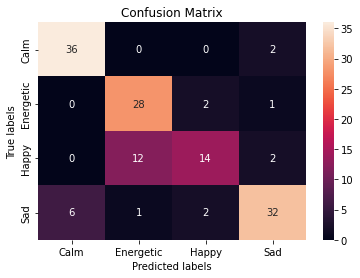

Accuracy Score 0.7971014492753623


In [21]:
# Measure the accuracy by creating confusion matrix
cm = confusion_matrix(Y_test,y_preds)

# Plot the confusion matrix
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)
labels = target['mood'].tolist()
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

# Show the accuracy score 
print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [22]:
spotify_df = pd.read_excel('spotify_dataset.xls')

In [23]:
spotify_df.isna().sum()

track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [24]:
spotify_df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5e2l2ZAMwHmrkdM4Z6NhAR,Shiloh Dynasty;Timmies,Vivid Pictures,Again,74,157205,False,0.603,0.204,7,-12.727,0,0.1120,0.479,0.07140,0.642,0.7100,74.688,5,chill
1,3XV5r1cMB2AlD2ir0v6mfm,yaeow;Neptune,The Way I Love You,The Way I Love You,60,162726,False,0.543,0.206,6,-18.037,1,0.0319,0.940,0.45300,0.385,0.1300,113.107,3,chill
2,5HsSsEeP3hU9QSfHZrzbtA,Finding Hope,Our Love,03:00:00,68,201951,False,0.550,0.147,0,-18.675,0,0.0404,0.563,0.00102,0.286,0.0346,81.991,4,chill
3,22I3h5AOENlH4CqXJsEbFR,Justine Skye;Tyga,Collide (feat. Tyga),Collide (feat. Tyga),75,260169,True,0.418,0.310,11,-9.869,0,0.0625,0.095,0.00000,0.216,0.1310,139.614,4,chill
4,0ri0Han4IRJhzvERHOZTMr,Pink Sweat$,The Prelude,At My Worst,74,170344,False,0.813,0.415,0,-5.926,1,0.0349,0.777,0.00000,0.131,0.6670,91.921,4,chill


In [25]:
mood_prep = spotify_df[['duration_ms', 'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo']]

In [26]:
col_features = mood_prep.columns[:]
col_features

Index(['duration_ms', 'danceability', 'acousticness', 'energy',
       'instrumentalness', 'liveness', 'valence', 'loudness', 'speechiness',
       'tempo'],
      dtype='object')

In [27]:
mood_trans = MinMaxScaler().fit_transform(mood_prep[col_features])
mood_trans_np = np.array(mood_prep[col_features])

mood_trans_np[10011]

array([ 1.96213e+05,  6.01000e-01,  1.75000e-01,  7.03000e-01,
        8.40000e-05,  5.71000e-01,  6.73000e-01, -6.24000e+00,
        3.79000e-02,  1.06164e+02])

In [28]:
# Join the model and the scaler in a Pipeline
pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300, batch_size=200,verbose=0))])

# Fit the Pipeline
pip.fit(X2,encoded_y)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('keras',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb75a6c07f0>)])

In [29]:
def predict_mood(preds):
    preds_features = np.array(preds[:]).reshape(-1,1).T
    # predict the features of the song
    results = pip.predict(preds_features)
    mood = np.array(target['mood'][target['encode']==int(results)])
    return str(mood[0])
    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")

In [30]:
res = []

for i in range(len(mood_trans_np)):
  res.append(predict_mood(mood_trans_np[i]))

In [31]:
spotify_df['Mood'] = np.resize(res,len(spotify_df))

In [32]:
res.count("Sad")

3721

In [33]:
res.count("Happy")

5078

In [34]:
res.count("Energetic")

4901

In [35]:
res.count("Calm")

1300

In [36]:
spotify_df.to_excel('MusicMood.xls')

In [37]:
Spotify = pd.read_excel("MusicMood.xls")
Spotify

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,0,5e2l2ZAMwHmrkdM4Z6NhAR,Shiloh Dynasty;Timmies,Vivid Pictures,Again,74,157205,False,0.603,0.204,...,0,0.1120,0.47900,0.071400,0.6420,0.7100,74.688,5,chill,Sad
1,1,3XV5r1cMB2AlD2ir0v6mfm,yaeow;Neptune,The Way I Love You,The Way I Love You,60,162726,False,0.543,0.206,...,1,0.0319,0.94000,0.453000,0.3850,0.1300,113.107,3,chill,Sad
2,2,5HsSsEeP3hU9QSfHZrzbtA,Finding Hope,Our Love,03:00:00,68,201951,False,0.550,0.147,...,0,0.0404,0.56300,0.001020,0.2860,0.0346,81.991,4,chill,Sad
3,3,22I3h5AOENlH4CqXJsEbFR,Justine Skye;Tyga,Collide (feat. Tyga),Collide (feat. Tyga),75,260169,True,0.418,0.310,...,0,0.0625,0.09500,0.000000,0.2160,0.1310,139.614,4,chill,Sad
4,4,0ri0Han4IRJhzvERHOZTMr,Pink Sweat$,The Prelude,At My Worst,74,170344,False,0.813,0.415,...,1,0.0349,0.77700,0.000000,0.1310,0.6670,91.921,4,chill,Sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,3pnCeZNsoRXi2b5DbsOpqV,Jason Ross;RUNN,Atlas,More To Life (feat. RUNN),36,224181,False,0.551,0.812,...,1,0.0482,0.22700,0.000004,0.1220,0.3840,110.020,4,dubstep,Happy
14996,14996,2p4Y8c7O0Tm48Zk6IAWcTo,SLANDER,Thrive,Second Life,41,376615,False,0.706,0.857,...,0,0.0397,0.00435,0.866000,0.1010,0.3000,129.994,4,dubstep,Sad
14997,14997,5gQI9ccczclMrKfPnfxpkD,Dirt Monkey,Primatology,High Grade,22,115201,False,0.709,0.975,...,0,0.1670,0.03960,0.498000,0.3310,0.3040,149.929,4,dubstep,Energetic
14998,14998,5ruT2dWSHtML4esT7doTzt,Borgore,"Ruined Dubstep - EP, Pt. 1",Cry Me a River,21,278851,True,0.536,0.416,...,0,0.3500,0.16800,0.001480,0.0715,0.1340,67.922,4,dubstep,Sad


In [38]:
Spotify["Mood"].value_counts()

Happy        5078
Energetic    4901
Sad          3721
Calm         1300
Name: Mood, dtype: int64

In [39]:
Spotify["popularity"].value_counts()

0      2116
22      455
21      414
23      362
20      320
       ... 
93        2
89        2
100       1
96        1
98        1
Name: popularity, Length: 96, dtype: int64

In [40]:
import io
from io import BytesIO

In [41]:
# Define the function for reccomendating songs based on predicted class
# Predicted class obtained from face-emotion detection 

def Recommend_Songs(pred_class):
    if pred_class == 'Disgust' or pred_class == 'Angry':
        Play = Spotify[Spotify['Mood'] == 'Calm']
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:50].reset_index(drop=True)
        display(Play)
        output = io.BytesIO()
        Play.to_excel(output, index=False)
        output.seek(0)
        return output.read()
        
    if pred_class == 'Happy' or pred_class == 'Surprise':
        Play = Spotify[Spotify['Mood'] == 'Happy']
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:50].reset_index(drop=True)
        display(Play)
        output = io.BytesIO()
        Play.to_excel(output, index=False)
        output.seek(0)
        return output.read()
        
    if pred_class == 'Fear':
        Play = Spotify[Spotify['Mood'] == 'Energetic']
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:50].reset_index(drop=True)
        display(Play)
        output = io.BytesIO()
        Play.to_excel(output, index=False)
        output.seek(0)
        return output.read()
        
    if pred_class == 'Sad':
        Play = Spotify[Spotify['Mood'] == 'Sad']
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:50].reset_index(drop=True)
        display(Play)
        output = io.BytesIO()
        Play.to_excel(output, index=False)
        output.seek(0)
        return output.read()

In [48]:
# Load the trained model
model_path = "./My_model_clean.h5"
emotion_model = load_model(model_path)

# Set emotion label
emotion_label = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Set expression reading time
now = time.time()
future = now + 7

# Create video capture object
cap = cv.VideoCapture(0)

# Load face detection model
face_model = cv.CascadeClassifier("haarcascade_frontalface_alt.xml")

# Get client id and secret from environment variables
client_id = '98f6dc457a2347d3831622bdb99455fa'
client_secret = '35eef58c4a094d4bb64ce541201d6cf5'
redirect_uri = 'http://localhost:8000/callback/'
scope = 'playlist-modify-public user-read-playback-state user-modify-playback-state'
userid = 'i3hxax845p8y75wqqh2n3mkrs'

# Credentials to access the Spotify Music Data
auth_manager = SpotifyOAuth(client_id=client_id,
                            client_secret=client_secret,
                            redirect_uri=redirect_uri,
                            scope=scope)

sp = spotipy.Spotify(auth_manager=auth_manager)
access_token = auth_manager.get_cached_token()

def drawFace(frame, frame_grey):
    faces = face_model.detectMultiScale(frame, minSize=(50,50))
    emotion = np.array([[0,0,0,0,0,0,0]])
    for a,b,c,d in faces:
        face = frame_grey[b:b+d,a:a+c]
        face = cv.resize(face, (48, 48))

        face = np.array(face)
        face = face.reshape(1, 48, 48, 1)

        emotion = emotion_model.predict(face/255)
        text = emotion_label[np.argmax(emotion)]

        cv.rectangle(frame, (a,b), (a+c, b+d), (0, 0, 255), 1)
        cv.putText(frame, text, (a,b-10),cv.FONT_HERSHEY_COMPLEX, 0.8, (0,0,255), 2)
    return emotion

def main():
    # run real time camera
    while True:
        # if failed to open camera
        if not cap.isOpened():
            print('open camera failed')
            break
        # read current frame image
        frame = cap.read()[1]
        frame = imutils.resize(frame, width=300)
        # construct prob canvas
        prob = np.ones((300, 500, 3), dtype='uint8')

        # transfer to grey image
        frame_grey = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        emotion = drawFace(frame, frame_grey)
        sum = emotion.sum()
        if not sum == 0:
            emotion = emotion / sum

        for i in range(0, 7):
            cv.putText(prob, emotion_label[i], (10, (i + 1) * 35 + 10), 
                       cv.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255),
                       1)
            dec_emo = emotion_label[np.argmax(emotion)]
            lr = 90 + int(emotion[0][i] * 300)
            cv.rectangle(prob, (90, i * 35 + 25), 
                         (90 + int(emotion[0][i] * 300), 
                          (i + 1) * 35 + 30), (0, 255, 0), -1)

        cv.imshow('video', frame)
        if time.time() > future:
            #print(dec_emo)
            break
        
        if cv.waitKey(1) == ord('q'):
            break
            
        recommended_songs_bytes = Recommend_Songs(dec_emo)
        recommended_songs_df=pd.read_excel(BytesIO(recommended_songs_bytes), engine='openpyxl')
        track_ids = recommended_songs_df["track_id"].tolist()
        track_uris=[]
        for i in track_ids:
            uri = 'spotify:track:'+i
            track_uris.append(uri)
            
        # create a new playlist
        resp = sp.user_playlist_create(userid, 
                               'New Playlist', 
                               public=True,
                               collaborative=False,
                               description='Have a good mood!')

        id = resp['uri'].split(':')[2]
        item = track_uris
        sp.playlist_add_items(playlist_id=id, items=item, position=None)

        playlist_uri = 'spotify:playlist:'+id
        sp.start_playback(context_uri = playlist_uri, offset={"position": 0})
            
    cap.release()

if __name__ == "__main__":
    main()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,12,3JvKfv6T31zO0ini8iNItO,Tom Odell,Long Way Down (Deluxe),Another Love,93,244360,True,0.445,0.537,...,0,0.0400,0.6950,0.000017,0.0944,0.1310,122.769,4,chill,Sad
1,5016,0mBP9X2gPCuapvpZ7TGDk3,Charlie Puth;Jung Kook;BTS,Left and Right (Feat. Jung Kook of BTS),Left and Right (Feat. Jung Kook of BTS),92,154486,False,0.881,0.592,...,1,0.0324,0.6190,0.000013,0.0901,0.7190,101.058,4,dance,Sad
2,4349,3WMj8moIAXJhHsyLaqIIHI,Zach Bryan,Something in the Orange,Something in the Orange,89,228013,False,0.369,0.192,...,0,0.0400,0.5550,0.000008,0.0954,0.1480,175.212,3,country,Sad
3,5559,3uUuGVFu1V7jTQL60S1r8z,Lost Frequencies;Calum Scott,Where Are You Now,Where Are You Now,88,148197,False,0.671,0.636,...,0,0.1030,0.5150,0.000411,0.1720,0.2620,120.966,4,dance,Sad
4,5949,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
5,5906,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
6,14999,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers;Halsey,Closer,Closer,84,244960,False,0.748,0.524,...,1,0.0338,0.4140,0.000000,0.1110,0.6610,95.010,4,edm,Sad
7,5008,6ocbgoVGwYJhOv1GgI9NsF,Ariana Grande,"thank u, next",7 rings,84,178626,True,0.778,0.317,...,0,0.3340,0.5920,0.000000,0.0881,0.3270,140.048,4,dance,Sad
8,5051,3Vi5XqYrmQgOYBajMWSvCi,Doja Cat,Planet Her,Need to Know,84,210560,True,0.664,0.609,...,1,0.0707,0.3040,0.000000,0.0926,0.1940,130.041,4,dance,Sad
9,5908,2VxeLyX666F8uXCJ0dZF8B,Lady Gaga;Bradley Cooper,A Star Is Born Soundtrack,Shallow,84,215733,False,0.572,0.385,...,1,0.0308,0.3710,0.000000,0.2310,0.3230,95.799,4,dance,Sad


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,12,3JvKfv6T31zO0ini8iNItO,Tom Odell,Long Way Down (Deluxe),Another Love,93,244360,True,0.445,0.537,...,0,0.0400,0.6950,0.000017,0.0944,0.1310,122.769,4,chill,Sad
1,5016,0mBP9X2gPCuapvpZ7TGDk3,Charlie Puth;Jung Kook;BTS,Left and Right (Feat. Jung Kook of BTS),Left and Right (Feat. Jung Kook of BTS),92,154486,False,0.881,0.592,...,1,0.0324,0.6190,0.000013,0.0901,0.7190,101.058,4,dance,Sad
2,4349,3WMj8moIAXJhHsyLaqIIHI,Zach Bryan,Something in the Orange,Something in the Orange,89,228013,False,0.369,0.192,...,0,0.0400,0.5550,0.000008,0.0954,0.1480,175.212,3,country,Sad
3,5559,3uUuGVFu1V7jTQL60S1r8z,Lost Frequencies;Calum Scott,Where Are You Now,Where Are You Now,88,148197,False,0.671,0.636,...,0,0.1030,0.5150,0.000411,0.1720,0.2620,120.966,4,dance,Sad
4,5949,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
5,5906,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
6,14999,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers;Halsey,Closer,Closer,84,244960,False,0.748,0.524,...,1,0.0338,0.4140,0.000000,0.1110,0.6610,95.010,4,edm,Sad
7,5008,6ocbgoVGwYJhOv1GgI9NsF,Ariana Grande,"thank u, next",7 rings,84,178626,True,0.778,0.317,...,0,0.3340,0.5920,0.000000,0.0881,0.3270,140.048,4,dance,Sad
8,5051,3Vi5XqYrmQgOYBajMWSvCi,Doja Cat,Planet Her,Need to Know,84,210560,True,0.664,0.609,...,1,0.0707,0.3040,0.000000,0.0926,0.1940,130.041,4,dance,Sad
9,5908,2VxeLyX666F8uXCJ0dZF8B,Lady Gaga;Bradley Cooper,A Star Is Born Soundtrack,Shallow,84,215733,False,0.572,0.385,...,1,0.0308,0.3710,0.000000,0.2310,0.3230,95.799,4,dance,Sad


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,5000,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,dance,Happy
1,4999,5IgjP7X4th6nMNDh4akUHb,Chris Brown,Indigo (Extended),Under The Influence,96,184613,True,0.733,0.690,...,0,0.0427,0.06350,0.000001,0.1050,0.310,116.992,4,dance,Happy
2,5849,1xzi1Jcr7mEi9K2RfzLOqS,Beyoncé,RENAISSANCE,CUFF IT,93,225388,True,0.780,0.689,...,1,0.1410,0.03680,0.000010,0.0698,0.642,115.042,4,dance,Happy
3,5409,4C6Uex2ILwJi9sZXRdmqXp,Nicki Minaj,Super Freaky Girl,Super Freaky Girl,92,170977,True,0.950,0.891,...,1,0.2410,0.06450,0.000018,0.3090,0.912,133.010,4,dance,Happy
4,5810,4zN21mbAuaD0WqtmaTZZeP,James Hype;Miggy Dela Rosa,Ferrari,Ferrari,90,186661,False,0.847,0.690,...,0,0.0493,0.01270,0.000060,0.0526,0.692,125.004,4,dance,Happy
5,5199,0hquQWY3xvYqN4qtiquniF,Doja Cat,Vegas (From the Original Motion Picture Soundt...,Vegas (From the Original Motion Picture Soundt...,90,182906,True,0.801,0.601,...,0,0.2550,0.07770,0.000032,0.1450,0.740,159.969,4,dance,Happy
6,8001,4zN21mbAuaD0WqtmaTZZeP,James Hype;Miggy Dela Rosa,Ferrari,Ferrari,90,186661,False,0.847,0.690,...,0,0.0493,0.01270,0.000060,0.0526,0.692,125.004,4,deep-house,Happy
7,5013,7ef4DlsgrMEH11cDZd32M6,Calvin Harris;Dua Lipa,One Kiss (with Dua Lipa),One Kiss (with Dua Lipa),89,214846,False,0.791,0.862,...,0,0.1100,0.03700,0.000022,0.0814,0.592,123.994,4,dance,Happy
8,5012,6Uj1ctrBOjOas8xZXGqKk4,Doja Cat,Planet Her,Woman,88,172626,True,0.824,0.764,...,0,0.0854,0.08880,0.002940,0.1170,0.881,107.998,4,dance,Happy
9,5653,0QBzMgT7NIeoCYy3sJCof1,Camila Cabello;Ed Sheeran,Bam Bam (feat. Ed Sheeran),Bam Bam (feat. Ed Sheeran),87,206070,False,0.756,0.697,...,1,0.0401,0.18200,0.000000,0.3330,0.956,94.996,4,dance,Happy


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,12,3JvKfv6T31zO0ini8iNItO,Tom Odell,Long Way Down (Deluxe),Another Love,93,244360,True,0.445,0.537,...,0,0.0400,0.6950,0.000017,0.0944,0.1310,122.769,4,chill,Sad
1,5016,0mBP9X2gPCuapvpZ7TGDk3,Charlie Puth;Jung Kook;BTS,Left and Right (Feat. Jung Kook of BTS),Left and Right (Feat. Jung Kook of BTS),92,154486,False,0.881,0.592,...,1,0.0324,0.6190,0.000013,0.0901,0.7190,101.058,4,dance,Sad
2,4349,3WMj8moIAXJhHsyLaqIIHI,Zach Bryan,Something in the Orange,Something in the Orange,89,228013,False,0.369,0.192,...,0,0.0400,0.5550,0.000008,0.0954,0.1480,175.212,3,country,Sad
3,5559,3uUuGVFu1V7jTQL60S1r8z,Lost Frequencies;Calum Scott,Where Are You Now,Where Are You Now,88,148197,False,0.671,0.636,...,0,0.1030,0.5150,0.000411,0.1720,0.2620,120.966,4,dance,Sad
4,5949,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
5,5906,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
6,14999,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers;Halsey,Closer,Closer,84,244960,False,0.748,0.524,...,1,0.0338,0.4140,0.000000,0.1110,0.6610,95.010,4,edm,Sad
7,5008,6ocbgoVGwYJhOv1GgI9NsF,Ariana Grande,"thank u, next",7 rings,84,178626,True,0.778,0.317,...,0,0.3340,0.5920,0.000000,0.0881,0.3270,140.048,4,dance,Sad
8,5051,3Vi5XqYrmQgOYBajMWSvCi,Doja Cat,Planet Her,Need to Know,84,210560,True,0.664,0.609,...,1,0.0707,0.3040,0.000000,0.0926,0.1940,130.041,4,dance,Sad
9,5908,2VxeLyX666F8uXCJ0dZF8B,Lady Gaga;Bradley Cooper,A Star Is Born Soundtrack,Shallow,84,215733,False,0.572,0.385,...,1,0.0308,0.3710,0.000000,0.2310,0.3230,95.799,4,dance,Sad


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,5000,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,dance,Happy
1,4999,5IgjP7X4th6nMNDh4akUHb,Chris Brown,Indigo (Extended),Under The Influence,96,184613,True,0.733,0.690,...,0,0.0427,0.06350,0.000001,0.1050,0.310,116.992,4,dance,Happy
2,5849,1xzi1Jcr7mEi9K2RfzLOqS,Beyoncé,RENAISSANCE,CUFF IT,93,225388,True,0.780,0.689,...,1,0.1410,0.03680,0.000010,0.0698,0.642,115.042,4,dance,Happy
3,5409,4C6Uex2ILwJi9sZXRdmqXp,Nicki Minaj,Super Freaky Girl,Super Freaky Girl,92,170977,True,0.950,0.891,...,1,0.2410,0.06450,0.000018,0.3090,0.912,133.010,4,dance,Happy
4,5810,4zN21mbAuaD0WqtmaTZZeP,James Hype;Miggy Dela Rosa,Ferrari,Ferrari,90,186661,False,0.847,0.690,...,0,0.0493,0.01270,0.000060,0.0526,0.692,125.004,4,dance,Happy
5,5199,0hquQWY3xvYqN4qtiquniF,Doja Cat,Vegas (From the Original Motion Picture Soundt...,Vegas (From the Original Motion Picture Soundt...,90,182906,True,0.801,0.601,...,0,0.2550,0.07770,0.000032,0.1450,0.740,159.969,4,dance,Happy
6,8001,4zN21mbAuaD0WqtmaTZZeP,James Hype;Miggy Dela Rosa,Ferrari,Ferrari,90,186661,False,0.847,0.690,...,0,0.0493,0.01270,0.000060,0.0526,0.692,125.004,4,deep-house,Happy
7,5013,7ef4DlsgrMEH11cDZd32M6,Calvin Harris;Dua Lipa,One Kiss (with Dua Lipa),One Kiss (with Dua Lipa),89,214846,False,0.791,0.862,...,0,0.1100,0.03700,0.000022,0.0814,0.592,123.994,4,dance,Happy
8,5012,6Uj1ctrBOjOas8xZXGqKk4,Doja Cat,Planet Her,Woman,88,172626,True,0.824,0.764,...,0,0.0854,0.08880,0.002940,0.1170,0.881,107.998,4,dance,Happy
9,5653,0QBzMgT7NIeoCYy3sJCof1,Camila Cabello;Ed Sheeran,Bam Bam (feat. Ed Sheeran),Bam Bam (feat. Ed Sheeran),87,206070,False,0.756,0.697,...,1,0.0401,0.18200,0.000000,0.3330,0.956,94.996,4,dance,Happy


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,5000,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,dance,Happy
1,4999,5IgjP7X4th6nMNDh4akUHb,Chris Brown,Indigo (Extended),Under The Influence,96,184613,True,0.733,0.690,...,0,0.0427,0.06350,0.000001,0.1050,0.310,116.992,4,dance,Happy
2,5849,1xzi1Jcr7mEi9K2RfzLOqS,Beyoncé,RENAISSANCE,CUFF IT,93,225388,True,0.780,0.689,...,1,0.1410,0.03680,0.000010,0.0698,0.642,115.042,4,dance,Happy
3,5409,4C6Uex2ILwJi9sZXRdmqXp,Nicki Minaj,Super Freaky Girl,Super Freaky Girl,92,170977,True,0.950,0.891,...,1,0.2410,0.06450,0.000018,0.3090,0.912,133.010,4,dance,Happy
4,5810,4zN21mbAuaD0WqtmaTZZeP,James Hype;Miggy Dela Rosa,Ferrari,Ferrari,90,186661,False,0.847,0.690,...,0,0.0493,0.01270,0.000060,0.0526,0.692,125.004,4,dance,Happy
5,5199,0hquQWY3xvYqN4qtiquniF,Doja Cat,Vegas (From the Original Motion Picture Soundt...,Vegas (From the Original Motion Picture Soundt...,90,182906,True,0.801,0.601,...,0,0.2550,0.07770,0.000032,0.1450,0.740,159.969,4,dance,Happy
6,8001,4zN21mbAuaD0WqtmaTZZeP,James Hype;Miggy Dela Rosa,Ferrari,Ferrari,90,186661,False,0.847,0.690,...,0,0.0493,0.01270,0.000060,0.0526,0.692,125.004,4,deep-house,Happy
7,5013,7ef4DlsgrMEH11cDZd32M6,Calvin Harris;Dua Lipa,One Kiss (with Dua Lipa),One Kiss (with Dua Lipa),89,214846,False,0.791,0.862,...,0,0.1100,0.03700,0.000022,0.0814,0.592,123.994,4,dance,Happy
8,5012,6Uj1ctrBOjOas8xZXGqKk4,Doja Cat,Planet Her,Woman,88,172626,True,0.824,0.764,...,0,0.0854,0.08880,0.002940,0.1170,0.881,107.998,4,dance,Happy
9,5653,0QBzMgT7NIeoCYy3sJCof1,Camila Cabello;Ed Sheeran,Bam Bam (feat. Ed Sheeran),Bam Bam (feat. Ed Sheeran),87,206070,False,0.756,0.697,...,1,0.0401,0.18200,0.000000,0.3330,0.956,94.996,4,dance,Happy


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,12,3JvKfv6T31zO0ini8iNItO,Tom Odell,Long Way Down (Deluxe),Another Love,93,244360,True,0.445,0.537,...,0,0.0400,0.6950,0.000017,0.0944,0.1310,122.769,4,chill,Sad
1,5016,0mBP9X2gPCuapvpZ7TGDk3,Charlie Puth;Jung Kook;BTS,Left and Right (Feat. Jung Kook of BTS),Left and Right (Feat. Jung Kook of BTS),92,154486,False,0.881,0.592,...,1,0.0324,0.6190,0.000013,0.0901,0.7190,101.058,4,dance,Sad
2,4349,3WMj8moIAXJhHsyLaqIIHI,Zach Bryan,Something in the Orange,Something in the Orange,89,228013,False,0.369,0.192,...,0,0.0400,0.5550,0.000008,0.0954,0.1480,175.212,3,country,Sad
3,5559,3uUuGVFu1V7jTQL60S1r8z,Lost Frequencies;Calum Scott,Where Are You Now,Where Are You Now,88,148197,False,0.671,0.636,...,0,0.1030,0.5150,0.000411,0.1720,0.2620,120.966,4,dance,Sad
4,5949,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
5,5906,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
6,14999,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers;Halsey,Closer,Closer,84,244960,False,0.748,0.524,...,1,0.0338,0.4140,0.000000,0.1110,0.6610,95.010,4,edm,Sad
7,5008,6ocbgoVGwYJhOv1GgI9NsF,Ariana Grande,"thank u, next",7 rings,84,178626,True,0.778,0.317,...,0,0.3340,0.5920,0.000000,0.0881,0.3270,140.048,4,dance,Sad
8,5051,3Vi5XqYrmQgOYBajMWSvCi,Doja Cat,Planet Her,Need to Know,84,210560,True,0.664,0.609,...,1,0.0707,0.3040,0.000000,0.0926,0.1940,130.041,4,dance,Sad
9,5908,2VxeLyX666F8uXCJ0dZF8B,Lady Gaga;Bradley Cooper,A Star Is Born Soundtrack,Shallow,84,215733,False,0.572,0.385,...,1,0.0308,0.3710,0.000000,0.2310,0.3230,95.799,4,dance,Sad


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,12,3JvKfv6T31zO0ini8iNItO,Tom Odell,Long Way Down (Deluxe),Another Love,93,244360,True,0.445,0.537,...,0,0.0400,0.6950,0.000017,0.0944,0.1310,122.769,4,chill,Sad
1,5016,0mBP9X2gPCuapvpZ7TGDk3,Charlie Puth;Jung Kook;BTS,Left and Right (Feat. Jung Kook of BTS),Left and Right (Feat. Jung Kook of BTS),92,154486,False,0.881,0.592,...,1,0.0324,0.6190,0.000013,0.0901,0.7190,101.058,4,dance,Sad
2,4349,3WMj8moIAXJhHsyLaqIIHI,Zach Bryan,Something in the Orange,Something in the Orange,89,228013,False,0.369,0.192,...,0,0.0400,0.5550,0.000008,0.0954,0.1480,175.212,3,country,Sad
3,5559,3uUuGVFu1V7jTQL60S1r8z,Lost Frequencies;Calum Scott,Where Are You Now,Where Are You Now,88,148197,False,0.671,0.636,...,0,0.1030,0.5150,0.000411,0.1720,0.2620,120.966,4,dance,Sad
4,5949,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
5,5906,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
6,14999,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers;Halsey,Closer,Closer,84,244960,False,0.748,0.524,...,1,0.0338,0.4140,0.000000,0.1110,0.6610,95.010,4,edm,Sad
7,5008,6ocbgoVGwYJhOv1GgI9NsF,Ariana Grande,"thank u, next",7 rings,84,178626,True,0.778,0.317,...,0,0.3340,0.5920,0.000000,0.0881,0.3270,140.048,4,dance,Sad
8,5051,3Vi5XqYrmQgOYBajMWSvCi,Doja Cat,Planet Her,Need to Know,84,210560,True,0.664,0.609,...,1,0.0707,0.3040,0.000000,0.0926,0.1940,130.041,4,dance,Sad
9,5908,2VxeLyX666F8uXCJ0dZF8B,Lady Gaga;Bradley Cooper,A Star Is Born Soundtrack,Shallow,84,215733,False,0.572,0.385,...,1,0.0308,0.3710,0.000000,0.2310,0.3230,95.799,4,dance,Sad


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Mood
0,12,3JvKfv6T31zO0ini8iNItO,Tom Odell,Long Way Down (Deluxe),Another Love,93,244360,True,0.445,0.537,...,0,0.0400,0.6950,0.000017,0.0944,0.1310,122.769,4,chill,Sad
1,5016,0mBP9X2gPCuapvpZ7TGDk3,Charlie Puth;Jung Kook;BTS,Left and Right (Feat. Jung Kook of BTS),Left and Right (Feat. Jung Kook of BTS),92,154486,False,0.881,0.592,...,1,0.0324,0.6190,0.000013,0.0901,0.7190,101.058,4,dance,Sad
2,4349,3WMj8moIAXJhHsyLaqIIHI,Zach Bryan,Something in the Orange,Something in the Orange,89,228013,False,0.369,0.192,...,0,0.0400,0.5550,0.000008,0.0954,0.1480,175.212,3,country,Sad
3,5559,3uUuGVFu1V7jTQL60S1r8z,Lost Frequencies;Calum Scott,Where Are You Now,Where Are You Now,88,148197,False,0.671,0.636,...,0,0.1030,0.5150,0.000411,0.1720,0.2620,120.966,4,dance,Sad
4,5949,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
5,5906,7795WJLVKJoAyVoOtCWqXN,Sam Smith,In The Lonely Hour,I'm Not The Only One,88,239316,False,0.677,0.485,...,1,0.0361,0.5290,0.000020,0.0766,0.4930,82.001,4,dance,Sad
6,14999,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers;Halsey,Closer,Closer,84,244960,False,0.748,0.524,...,1,0.0338,0.4140,0.000000,0.1110,0.6610,95.010,4,edm,Sad
7,5008,6ocbgoVGwYJhOv1GgI9NsF,Ariana Grande,"thank u, next",7 rings,84,178626,True,0.778,0.317,...,0,0.3340,0.5920,0.000000,0.0881,0.3270,140.048,4,dance,Sad
8,5051,3Vi5XqYrmQgOYBajMWSvCi,Doja Cat,Planet Her,Need to Know,84,210560,True,0.664,0.609,...,1,0.0707,0.3040,0.000000,0.0926,0.1940,130.041,4,dance,Sad
9,5908,2VxeLyX666F8uXCJ0dZF8B,Lady Gaga;Bradley Cooper,A Star Is Born Soundtrack,Shallow,84,215733,False,0.572,0.385,...,1,0.0308,0.3710,0.000000,0.2310,0.3230,95.799,4,dance,Sad
